In [ ]:
# jun hirabayashi jun@hirax.net twitter: @hirax

# 画像ファイルからの解析コード

In [1]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt

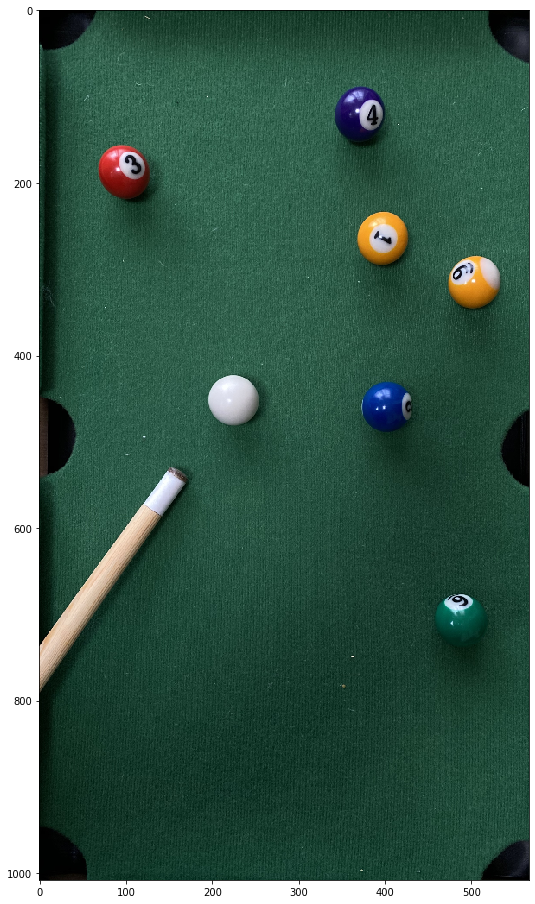

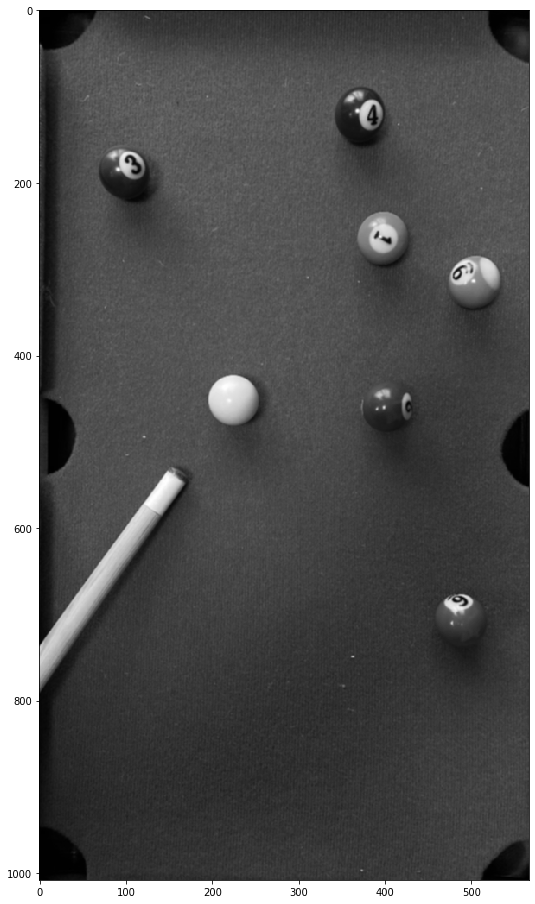

In [2]:
img = cv2.imread( 'IMG_2496.jpg' )
grayImg = cv2.cvtColor( cv2.GaussianBlur( img, (3, 3), 0 ), 
                                      cv2.COLOR_RGB2GRAY )

cimg = cv2.cvtColor( img, cv2.COLOR_BGR2RGB )
plt.figure( figsize=(30,16) ); plt.imshow( cimg )
plt.figure( figsize=(30,16) ); plt.imshow( grayImg, cmap="gray" )

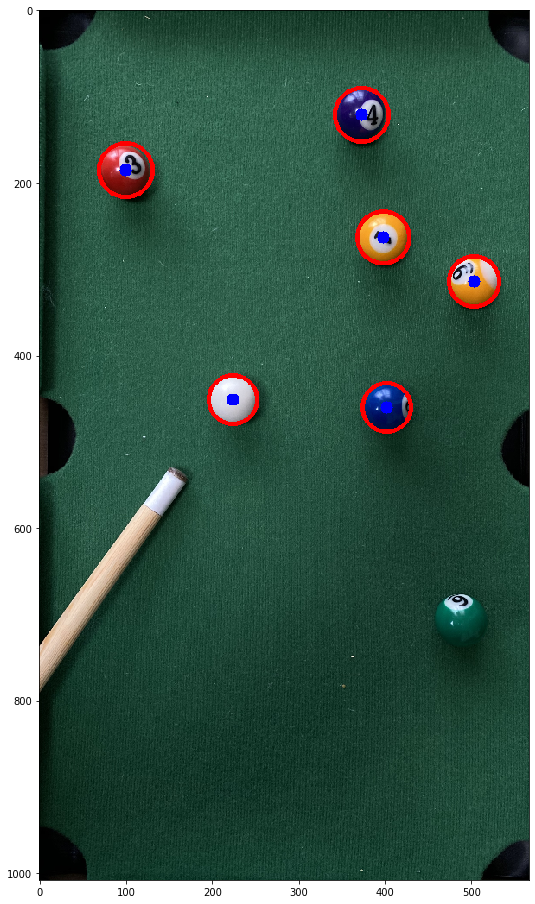

In [3]:
def img2balls( img, grayImg ):
    balls = cv2.HoughCircles( grayImg, cv2.HOUGH_GRADIENT, 1, 60,
                    param1=70, param2=10, minRadius=28,maxRadius=32 )
    # ポケットがボールとして抽出されない対策もして、各ボールの「位置・大きさ」を返す
    return  [c for c in balls[0,:] if np.sum( img[ int(c[1]), int(c[0]) ] ) > 10]

balls = img2balls( img, grayImg )

cImg = cv2.cvtColor( img, cv2.COLOR_BGR2RGB ) # 抽出したボールを描く
for ball in balls:
    cv2.circle( cImg, ( ball[0], ball[1] ), ball[2], (255,0,0), 3 ) # 外線を描く
    cv2.circle( cImg, ( ball[0], ball[1] ), 2,    (0,0,255), 10 )   # 中心を描く

plt.figure( figsize=(30,16) ); plt.imshow( cImg )

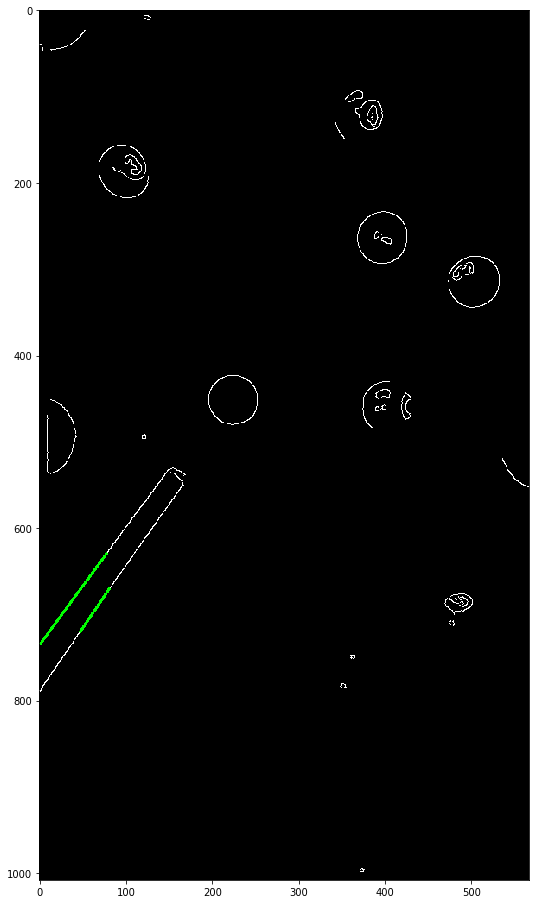

In [4]:
def findCue( img, isVisualize ): # キューを検出する
    edges = cv2.Canny( cv2.GaussianBlur( img[:, :, 2], (11, 11), 0 ),  
                                    50, 70, apertureSize = 3 )
    lines = cv2.HoughLinesP( edges, 1, np.pi/180, 1, 3, 40 )
    centers = []; angles = []
    if isVisualize: tmpImg = cv2.cvtColor( edges, cv2.COLOR_BGR2RGB ) 
    for line in lines:
        x1,y1, x2, y2 = line[0] # 両端点
        centers.append( [  ( x1 + x2 ) / 2., ( y1 + y2 ) / 2. ]  )
        angles.append(  (y2 - y1) / (x2 - x1) )
        if isVisualize: cv2.line( tmpImg,(x1,y1),(x2,y2),(0,255,0),2)
    if isVisualize: return centers, angles, tmpImg 
    else: return centers, angles, None

centers, angles, tmpImg = findCue( img, True )
plt.figure(figsize=(30,16)); plt.imshow( tmpImg)

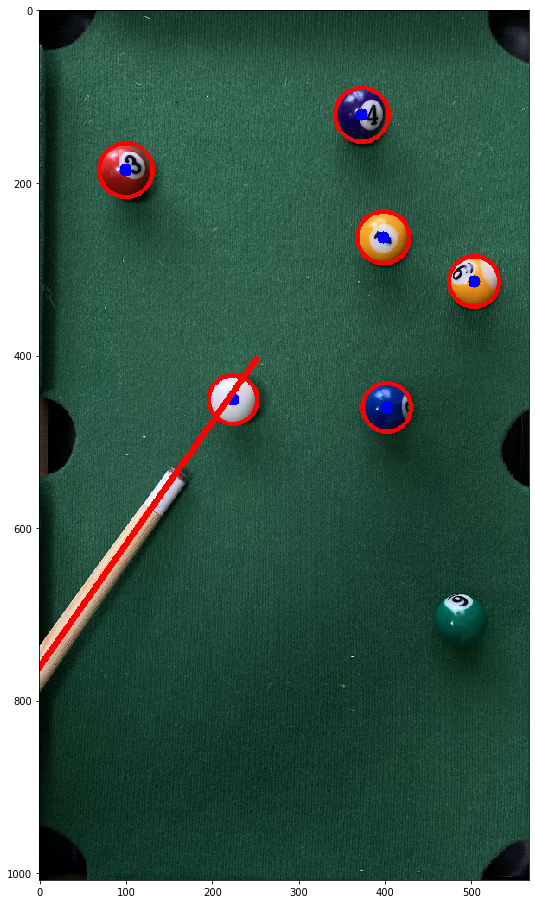

In [5]:
def findCueCenterLine( centers, angles ):
    center =  np.average( centers, axis=0 )
    angle = np.average( angles ) 
    return center, angle

center, angle = findCueCenterLine( centers, angles )

cv2.line( cImg, ( int( center[0]-200), int(center[1]-200*angle) ), 
                      ( int( center[0]+200), int(center[1]+200*angle) ),
                      ( 255, 0, 0 ), 5 )
plt.figure( figsize=(30,16) ); plt.imshow( cImg)

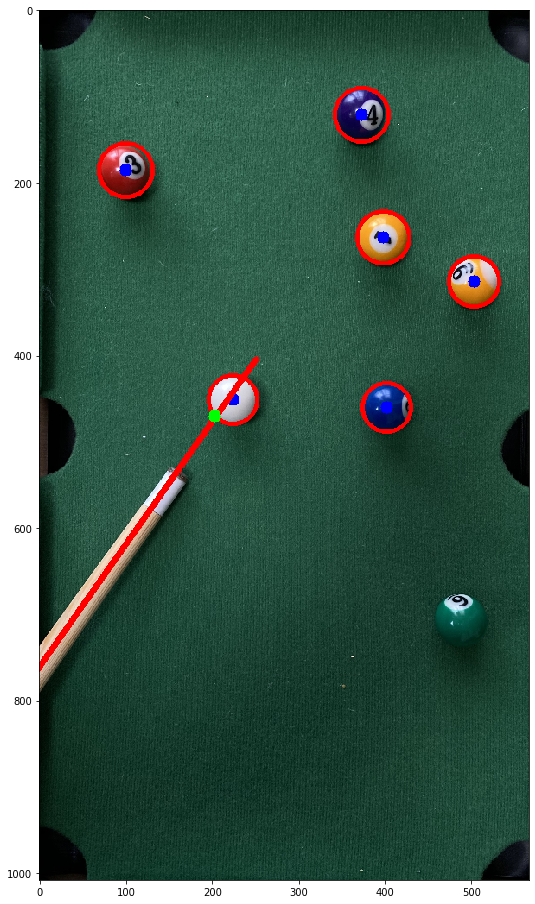

In [6]:
# 手玉のどの部分をキューを撞くかを求める（線分の手球の交点を検出する

# conda install -c anaconda geos


# conda install -c conda-forge shapely
from shapely.geometry import LineString
from shapely.geometry import Point

def findIntersection( center, angle, balls, cimg ): # imgに画像を渡すと可視化する
    # キュー位置・方向の情報を使い、キューを表す線分をsharpelyのLineで表現
    line = LineString( [ ( int( center[0]-200),  int(center[1]-200*angle) ), # 両端指定
                                 ( int( center[0]+200), int(center[1]+200*angle) )  ] ) 
    
    for idx, ball in enumerate( balls ):
        point = Point( [ ball[ 0 ], ball[ 1 ] ] ) # 中心位置を指定
        circle = point.buffer( ball[ 2 ] ).boundary # 大きさを指定して境界円を作る
        intersections = circle.intersection( line ) # 線分と境界円の交点を見つける
        if intersections:  # キューから手玉より遠い他ボールは、キュー線分と交わらない前提
            indexOfNextBall = idx
            indexOfIntersection = np.argmin( intersections.distance( Point( center ) ) )#  1番近い交点 
            intersection = [ intersections[ indexOfIntersection ].x , intersections[ indexOfIntersection ].y ] 
            if bool( cimg.any() ): cv2.circle( cImg, 
                   ( int( intersections[ indexOfIntersection ].x ),  # 交点を描く
                     int( intersections[ indexOfIntersection ].y ) ), 2, ( 0, 255, 0 ), 10 )
            return indexOfNextBall, intersection, indexOfIntersection
            #break

indexOfNextBall, intersection, indexOfIntersection = findIntersection( 
                                                      center, angle, balls, cimg )

plt.figure(figsize=(30, 16) ); plt.imshow( cImg )



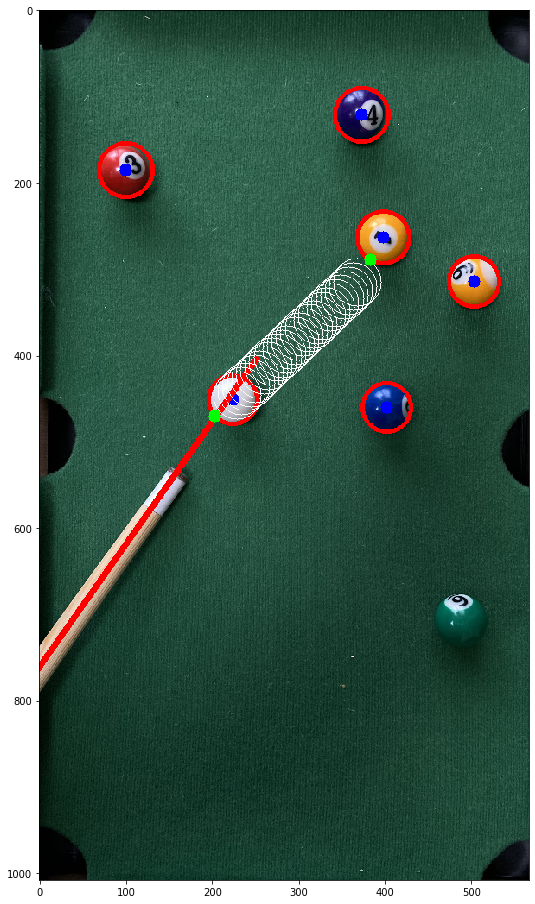

In [7]:

def moveBall( step, balls, indexOfNextBall, intersection, cImg ):
    pos = balls[ indexOfNextBall ][ :2 ]
    vec = np.array( [ balls[ indexOfNextBall ][0] - intersection[0],     
                              balls[ indexOfNextBall ][1] - intersection[1] ] ) / 4.
    for t in range( step ):
        pos = pos + vec
        if bool( cimg.any() ): 
            cv2.circle( cImg, ( int( pos[ 0 ] ), int( pos[ 1 ] ) ), 
                             balls[ indexOfNextBall ][ 2 ],  ( 255, 255, 255 ), 1 )
        for idx, ball in enumerate( balls ): # 衝突検知
            if idx != indexOfNextBall:
                if np.linalg.norm( ball[:2]-pos, ord=2) < 60:
                    indexOfNextBall = idx
                    intersection = np.average( [ ball[:2], pos ], axis=0 )
                    if bool( cimg.any() ): 
                        cv2.circle( cImg, ( int( intersection[0] ), int( intersection[1] ) ),
                                   2, (0,255,0), 10 ) #次の交点を描く
                    break 
        else:
            continue
        break
    return indexOfNextBall, intersection

indexOfNextBall, intersection = moveBall( 50, balls, indexOfNextBall, intersection, cImg )

plt.figure( figsize=(30,16) ); plt.imshow( cImg )


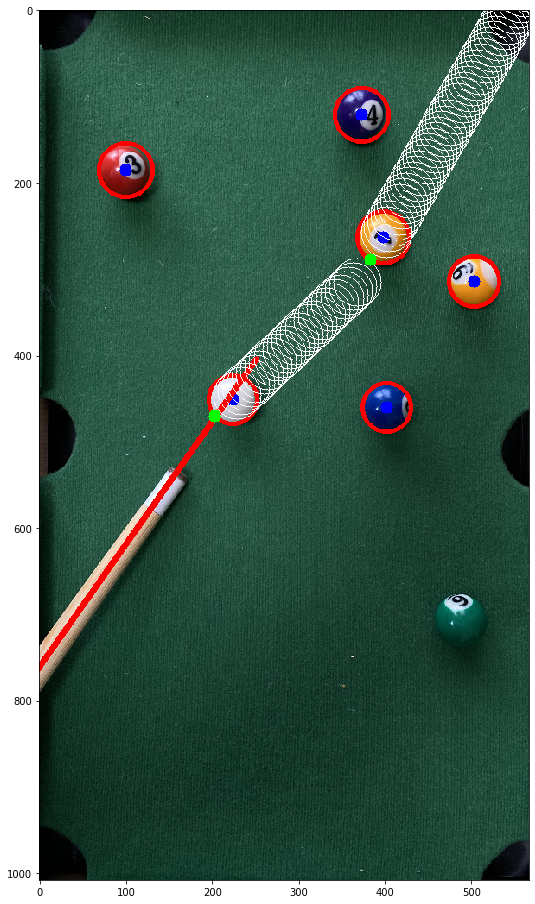

In [8]:

indexOfNextBall, intersection = moveBall( 50, balls, indexOfNextBall, intersection, cImg )

plt.figure( figsize=(30,16) ); plt.imshow( cImg )


# ビデオカメラ対応

In [ ]:
cap = cv2.VideoCapture( 1 )
while True:
    ret,img = cap.read(); cImg = img.copy()
    grayImg = cv2.cvtColor( cv2.GaussianBlur( img, (3, 3), 0 ), cv2.COLOR_RGB2GRAY )
    balls = img2balls( img, grayImg )
    centers, angles, tmpImg = findCue( img, False )
    center, angle = findCueCenterLine( centers, angles )
    indexOfNextBall, intersection, indexOfIntersection = findIntersection( center, angle, balls, cImg )
    indexOfNextBall, intersection = moveBall( 50, balls, indexOfNextBall, intersection, cImg )
    indexOfNextBall, intersection = moveBall( 50, balls, indexOfNextBall, intersection, cImg )
    cv2.imshow( 'image', cImg)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

cap.release()
cv2.destroyAllWindows()